# Diferenças finitas


\begin{equation*}
y''=p( x) y'( x) +q( x) y( x) +r( x) ,\quad y_{0} =\alpha ,\quad y_{N+1} =\beta ,\quad a\leq x\leq b
\end{equation*}

## Aproximando a primeira derivada

### Aproximando para frente

\begin{equation}
y( x_{i+1}) =y( x_{i}) +h\ y'( x_{i}) +\frac{h^{2}}{2} y''( x_{i}) +\frac{h^{3}}{6} y^{( 3)}( x_{i}) +\frac{h^{4}}{24} y^{( 4)}( x_{i}) +\cdots 
\end{equation}

truncando os termos de $\displaystyle h^{2}$:

\begin{equation*}
y'( x_{i}) =\frac{y( x_{i+1}) -y( x_{i}) +\mathcal{O}\left( h^{2}\right)}{h} \Longrightarrow \boxed{y'( x_{i}) =\frac{y_{i+1} -y_{i}}{h} +\mathcal{O}( h)}
\end{equation*}

### Aproximando para trás

\begin{equation}
y( x_{i-1}) =y( x_{i}) -h\ y'( x_{i}) +\frac{h^{2}}{2} y''( x_{i}) -\frac{h^{3}}{6} y^{( 3)}( x_{i}) +\frac{h^{4}}{24} y^{( 4)}( x_{i}) +\cdots 
\end{equation}

truncando os termos de $\displaystyle h^{2}$:

\begin{equation*}
y'( x_{i}) =\frac{y( x_{i}) -y( x_{i+1}) +\mathcal{O}\left( h^{2}\right)}{h} \Longrightarrow \boxed{y'( x_{i}) =\frac{y_{i} -y_{i-1}}{h} +\mathcal{O}( h)}
\end{equation*}

### Diferença central

Subtraindo as (1) e (2):

\begin{equation*}
y( x_{i+1}) -y( x_{i-1}) =2hy'( x_{i}) +\mathcal{O}\left( h^{3}\right) \Longrightarrow y'( x_{i}) =\frac{y( x_{i+1}) -y( x_{i-1}) +\mathcal{O}\left( h^{3}\right)}{2h}
\end{equation*}

\begin{equation*}
\boxed{y'( x_{i}) =\frac{y_{i+1} -y_{i-1}}{2h} +\mathcal{O}\left( h^{2}\right)}
\end{equation*}

## Aproximando segunda derivada

Somando as (1) e (2):

\begin{equation*}
y( x_{i+1}) +y( x_{i-1}) =2y( x_{i}) +\mathcal{h^{2} y''( x_{i}) +O}\left( h^{4}\right) \Longrightarrow \mathcal{y''( x_{i})} =\frac{y( x_{i+1}) +y( x_{i-1}) -2y( x_{i}) +\mathcal{O}\left( h^{4}\right)}{h^{2}}
\end{equation*}

\begin{equation*}
\boxed{\mathcal{y''( x_{i})} =\frac{y_{i+1} -2y_{i} +y_{i-1}}{h^{2}} +\mathcal{O}\left( h^{2}\right)}
\end{equation*}

## Discretizando um sistema linear de segunda ordem

\begin{align*}
\frac{y_{i+1} -2y_{i} +y_{i-1}}{h^{2}} =p( x_{i})\left(\frac{y_{i+1} -y_{i-1}}{2h}\right) +q( x_{i}) y_{i} +r( x_{i}) &
\Longrightarrow y_{i+1} -2y_{i} +y_{i-1} =\frac{h}{2} p( x_{i})( y_{i+1} -y_{i-1}) +h^{2} q( x_{i}) y_{i} +h^{2} r( x_{i})\\
& \Longrightarrow y_{i-1}\left( 1+\frac{h}{2} p( x_{i})\right) -y_{i}\left( 2+h^{2} q( x_{i})\right) +y_{i+1}\left( 1-\frac{h}{2} p( x_{i})\right) =h^{2} r( x_{i})
\end{align*}

\begin{equation*}
\boxed{A_{i} y_{i-1} +B_{i} y_{i} +C_{i} y_{i+1} =D_{i}}
\end{equation*}

\begin{equation*}
A_{i} =1+\frac{h}{2} p( x_{i}) ,\quad B_{i} =-2-h^{2} q( x_{i}) ,\quad C_{i} =1-\frac{h}{2} p( x_{i}) ,\quad D_{i} =h^{2} r( x_{i})
\end{equation*}

\begin{equation*}
\left\{\begin{array}{ l }
B_{1} y_{1} +C_{1} y_{2} =D_{1} - A_{1} \alpha\\
A_{2} y_{1} +B_{2} y_{2} +C_{2} y_{3} =D_{2}\\
\vdots \\
A_{N-1} y_{N-2} +B_{N-1} y_{N-1} +C_{N-1} y_{N} =D_{N-1}\\
A_{N} y_{N-2} +B_{N} y_{N} =D_{N}-C_{N} \beta
\end{array}\right. 
\end{equation*}

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from typing import Callable

In [56]:
class LinearFDM:
    def __init__(self, p: Callable, q: Callable, r: Callable, 
                    x0: float, y0: float, xf: float, yf: float, h : float) -> None:

        self.x0, self.xf = x0, xf
        self.y0, self.yf = y0, yf
        N = int((xf - x0)/h)
        self.x = x0 + h*np.arange(N)

        A, B, C, self.D = 1 + h*p(self.x)/2, -2-h**2*q(self.x), 1-h*p(self.x)/2, h**2*r(self.x)
        self.D[1] -= A[1]*y0
        self.D[-1] -= C[-1]*yf

        self.M = np.zeros((N-1, N-1))
        self.M[0, :2] = B[0], C[0]
        for i in range(1, N-2):
            self.M[i, i-1:i+2] = A[i], B[i], C[i]
        self.M[-1, -2:] = A[-1], B[-1]
    
    def inv(self) -> tuple:
        y = np.linalg.inv(self.M).dot(self.D[1:])
        return np.r_[self.x, self.xf], np.r_[self.y0, y, self.yf]

def table(x, y) -> None:
    display(HTML(pd.DataFrame({'x':x, 'y':y}).to_html()))

46 µs ± 9.28 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


,x,y
0,1.0,1.000000
1,1.1,1.093876
2,1.2,1.183023
3,1.3,1.276391
4,1.4,1.373175
5,1.5,1.472787
6,1.6,1.574780
7,1.7,1.678805
8,1.8,1.784585
9,1.9,1.891891


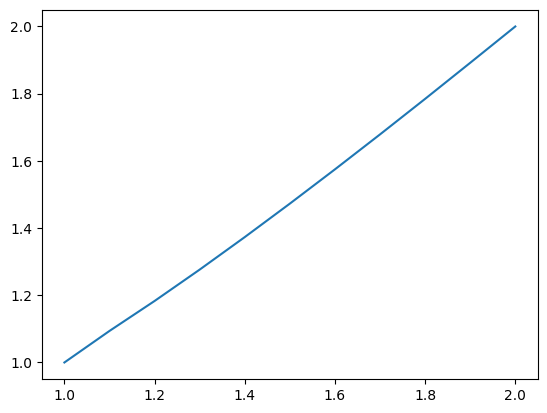

In [22]:
solver = LinearFDM(
    p= lambda x: -2/x, 
    q= lambda x: 2/x**2, 
    r= lambda x: np.sin(np.log(x))/x**2, 
    x0=1, y0=1, xf=2, yf=2, h=0.1
)
%timeit x, y = solver.inv()
table(x, y)
plt.plot(x, y)
plt.show()

# Diferenças finitas para PVC não-linear

\begin{equation*}
y''=f( x,\ y,\ y') \Longrightarrow \frac{y_{i+1} -2y_{i} +y_{i-1}}{h^{2}} -f\left( x,\ y_{i} ,\ \frac{y_{i+1} -y_{i-1}}{2h}\right) =0
\end{equation*}

\begin{equation*}
g_{i} =y_{i+1} -2y_{i} +y_{i-1} -h^{2} f\left( x,\ y_{i} ,\ \frac{y_{i+1} -y_{i-1}}{2h}\right)
\end{equation*}

\begin{equation*}
\overline{y}^{( k+1)} =\overline{y}^{( k)} -\left( J^{-1} \cdot \overline{g}\right) |_{\overline{y}^{( k)}}
\end{equation*}

\begin{equation*}
\overline{y} =( y_{1} ,\cdots ,\ y_{N})^{T} ,\quad \overline{g} =( g_{1} ,\cdots ,g_{N})
\end{equation*}

\begin{equation*}
\partial _{i-1} g_{i} =1+\frac{h}{2} \partial _{y'} f\left( x,\ y_{i} ,\ \frac{y_{i+1} -y_{i-1}}{2h}\right) = A_i
\end{equation*}

\begin{equation*}
\partial _{i} g_{i} =-2-h^{2} \partial _{y} f\left( x,\ y_{i} ,\ \frac{y_{i+1} -y_{i-1}}{2h}\right) = B_i
\end{equation*}

\begin{equation*}
\partial _{i+1} g_{i} =1-\frac{h}{2} \partial _{y'} f\left( x,\ y_{i} ,\ \frac{y_{i+1} -y_{i-1}}{2h}\right) = D_i
\end{equation*}

\begin{equation*}
J=\begin{pmatrix}
\partial _{1} g_{1} & \partial _{2} g_{1} & \cdots  & \partial _{N} g_{1}\\
\partial _{1} g_{2} & \partial _{2} g_{2} & \cdots  & \partial _{N} g_{2}\\
\vdots  & \vdots  & \ddots  & \vdots \\
\partial _{1} g_{N} & \partial _{2} g_{N} & \cdots  & \partial _{N} g_{N}
\end{pmatrix} =\begin{pmatrix}
B_{1} & C_{1} & 0 & \cdots  & 0 & 0 & 0\\
A_{2} & B_{2} & C_{2} & \cdots  & 0 & 0 & 0\\
0 & A_{3} & B_{3} & \cdots  & 0 & 0 & 0\\
\vdots  & \vdots  & \vdots  & \ddots  & \vdots  & \vdots  & \vdots \\
0 & 0 & 0 & \cdots  & B_{N-2} & C_{N-2} & 0\\
0 & 0 & 0 & \cdots  & A_{N-1} & B_{N-1} & C_{N-1}\\
0 & 0 & 0 & \cdots  & 0 & A_{N} & B_{N}
\end{pmatrix}
\end{equation*}




In [54]:
class NonLinearFDM:
    def __init__(self, f: Callable, fy: Callable, fdy: Callable, 
                    x0: float, y0: float, xf: float, yf: float, h : float) -> None:

        self.f, self.fy, self.fdy = f, fy, fdy
        self.x0, self.xf = x0, xf
        self.y0, self.yf = y0, yf
        self.h = h
        self.N = int((xf - x0)/h)
        self.x = x0 + h*np.arange(self.N+1)
        self.y = np.linspace(y0, yf, self.N+1)
    
    def dy(self, i):
        '''
        Forma discreta da primeira derivada

        i: int, índice da malha.    
        '''
        return (self.y[i+1] - self.y[i-1])/(2*self.h)

    def A(self, i):
        '''
        Componente da diagonal inferior do jacobiano: $A_i = \partial _{i-1} g_{i}$

        i: int, índice da malha.    
        '''
        return 1 + (self.h/2)*self.fdy(self.x[i], self.y[i], self.dy(i))

    def B(self, i):
        '''
        Componente da diagonal principal do jacobiano: $B_i = \partial _{i} g_{i}$

        i: int, índice da malha.    
        '''        
        return -2 - (self.h**2)*self.fy(self.x[i], self.y[i], self.dy(i))
    
    def C(self, i):
        '''
        Componente da diagonal superior do jacobiano: $B_i = \partial _{i+1} g_{i}$

        i: int, índice da malha.    
        '''        
        return 1 - (self.h/2)*self.fdy(self.x[i], self.y[i], self.dy(i))
    
    @property
    def J(self):
        '''
        Jacobiano
        '''
        n = self.N-1
        J = np.zeros((n, n))
        J[0, :2] = self.B(1), self.C(1)
        for i in range(1, n-1): # iterando pelas linhas do jacobiano (sem contar as extremidades)
            J[i, i-1:i+2] = self.A(i+1), self.B(i+1), self.C(i+1)
        J[-1, -2:] = self.A(n), self.B(n)
        return J
    
    @property
    def G(self):
        '''
        Sistema discretizado: $G \approx 0$
        '''
        return np.stack([
            self.y[i+1] - 2*self.y[i] + self.y[i-1] - (self.h**2)*self.f(self.x[i], self.y[i], self.dy(i))
            for i in range(1, self.N)
        ])
    
    def step(self):
        self.y[1:self.N] -= np.linalg.inv(self.J).dot(self.G)
        return self.y

,x,y
0,1.0,17.000000
1,1.1,15.754503
2,1.2,14.771740
3,1.3,13.995677
4,1.4,13.386297
5,1.5,12.914252
6,1.6,12.557538
7,1.7,12.299326
8,1.8,12.126529
9,1.9,12.028814


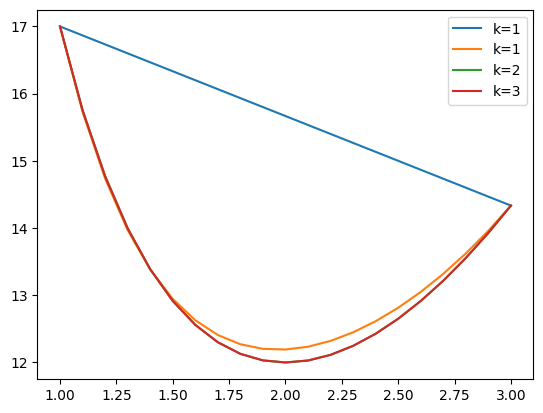

In [70]:
solver = NonLinearFDM(
    f= lambda x, y, dy: (1/8)*(32 + 2*x**3 - y*dy), 
    fy= lambda x, y, dy: -dy/8, 
    fdy= lambda x, y, dy: -y/8, 
    x0=1, y0=17, xf=3, yf=43/3, h=0.1
)
plt.plot(solver.x, solver.y, label='k=1')
for k in range(3):
    plt.plot(solver.x, solver.step(), label=f'k={k+1}')
plt.legend()
table(solver.x, solver.y)